In [1]:
import cv2
import os
import random
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def brightness(img):
    def average_with_noise_removal(numbers):
        valid_numbers = [n for n in numbers if 30 <= n <= 120]
        if len(valid_numbers) == 0:
            return 0
        mean = sum(valid_numbers) / len(valid_numbers)
        std_dev = (sum([(x - mean) ** 2 for x in valid_numbers]) / len(valid_numbers)) ** 0.5
        filtered_numbers = [n for n in valid_numbers if abs(n - mean) <= std_dev]

        return sum(filtered_numbers) / len(filtered_numbers) if filtered_numbers else 0

    def check_brightness(image):
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        v_channel = hsv_image[:, :, 2]
        corners = [v_channel[0, 0], v_channel[0, -1], v_channel[-1, 0], v_channel[-1, -1]]
        corners_non_zero = all(corner > 0 for corner in corners)
        any_pixel_brighter_than = np.any(v_channel > 40)

        return corners_non_zero and any_pixel_brighter_than, average_with_noise_removal(corners)
    
    status, value = check_brightness(img)
    if status:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        value = - int(value)
        h, s, v = cv2.split(hsv)
        v = cv2.add(v, value)
        v[v > 255] = 255
        v[v < 0] = 0
        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [131]:
def process_contours(closing, max_area_thresh, max_len_thresh, max_contours):
    area_thresh = 10
    len_thresh = 10

    rows, cols = closing.shape

    # 创建一个副本以进行操作
    processed_img = closing.copy()

    # 遍历图像的每一个像素
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            # 仅针对白色像素
            if closing[i, j] == 255:
                # 获取四邻域像素值
                up = closing[i-1, j]
                down = closing[i+1, j]
                left = closing[i, j-1]
                right = closing[i, j+1]

                # 检查是否只与上下或左右相邻
                if (up == 255 and down == 255 and left != 255 and right != 255) or \
                        (up != 255 and down != 255 and left == 255 and right == 255):
                    processed_img[i, j] = 0  # 移除该像素点
    
    closing = processed_img.copy()
    
    contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    while len(contours) >= max_contours and (area_thresh < max_area_thresh or len_thresh < max_len_thresh):
        for contour in contours:
            area = cv2.contourArea(contour)
            arealen = cv2.arcLength(contour, True)
            if area < area_thresh or arealen < len_thresh:
                cv2.drawContours(closing, [contour], -1, 0, thickness=cv2.FILLED)

        contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        if area_thresh < max_area_thresh:
            area_thresh += 1
        if len_thresh < max_len_thresh:
            len_thresh += 1
            
    return closing

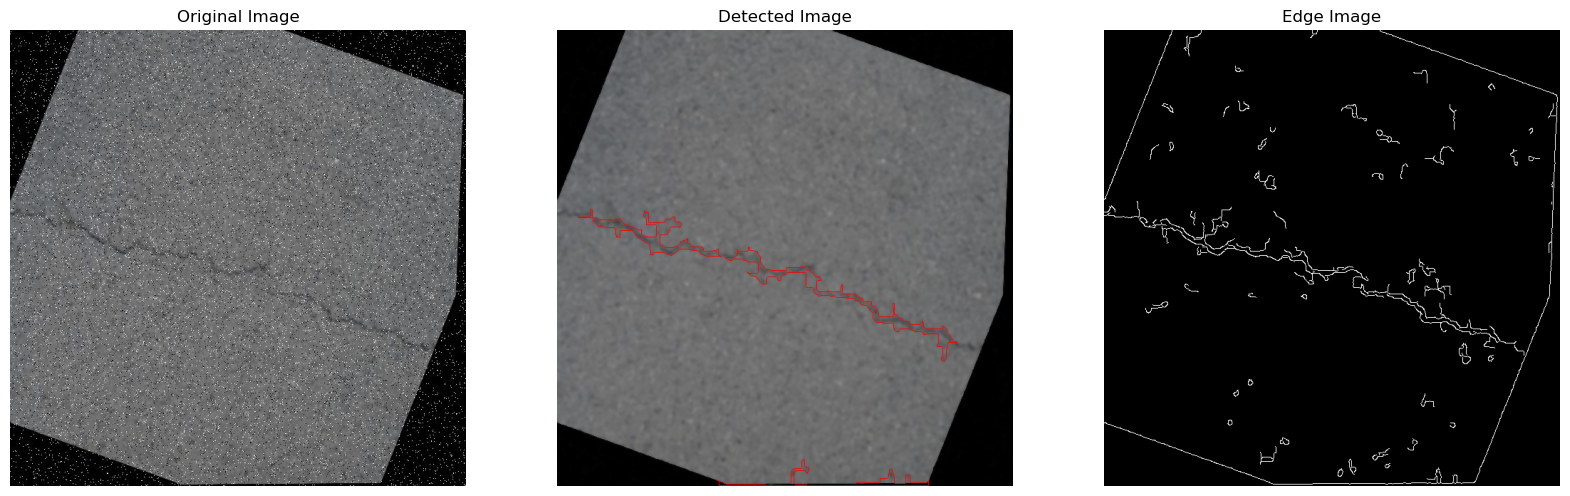

In [180]:
def process(img_path):
    img = cv2.imread(img_path)
    ori = img
    img = cv2.medianBlur(img, 5)
    img = cv2.bilateralFilter(img, 5, 75, 75)
    img = brightness(img)

    k = np.ones((5, 5), dtype=np.uint8)
    open = cv2.morphologyEx(img, cv2.MORPH_OPEN, k, iterations=2)

    contours = []
    clipLimitA=2.0
    while len(contours) <= 30:
        clahe = cv2.createCLAHE(clipLimit=clipLimitA, tileGridSize=(16,16))
        cl1 = clahe.apply(cv2.cvtColor(open, cv2.COLOR_BGR2GRAY))
        edges = cv2.Canny(cl1, 70, 200)
        kernel = np.ones((5, 5), np.uint8)
        closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=3)
        contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        clipLimitA = clipLimitA + 1

    max_area_thresh = 200
    max_len_thresh = 200
    max_contours = 1

    closing = process_contours(closing, max_area_thresh, max_len_thresh, max_contours)

    contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, contours, -1, (0, 0, 255), 1)
    
    return ori, img, edges

folder_path = 'data'
jpg_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
random_file = random.choice(jpg_files)
img_path = os.path.join(folder_path, random_file)
ori, img, edges = process(img_path)
ori = cv2.cvtColor(ori, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1) 
plt.imshow(ori)
plt.title('Original Image')
plt.axis('off') 

plt.subplot(1, 3, 2) 
plt.imshow(img, cmap='gray')
plt.title('Detected Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edges)
plt.title('Edge Image')
plt.axis('off')

plt.show()